In [1]:
!pip install torch torchvision


In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import files
uploaded = files.upload()


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [4]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
from zipfile import ZipFile
file_name = "/content/breast-ultrasound-images-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
print('Done')

Done


In [6]:
import os

# Path to the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

import shutil


# Path to the 'normal' directory
normal_dir_path = '/content/Dataset_BUSI_with_GT/normal'

# Check if the directory exists
if os.path.exists(normal_dir_path) and os.path.isdir(normal_dir_path):
    # Remove the 'normal' directory and all its contents
    shutil.rmtree(normal_dir_path)
    print(f"'{normal_dir_path}' has been removed.")
else:
    print(f"The directory '{normal_dir_path}' does not exist or is not a directory.")

all_files = os.listdir(dataset_dir)
print(all_files)


'/content/Dataset_BUSI_with_GT/normal' has been removed.
['malignant', 'benign']


In [7]:
def check_images_and_masks(directory):
    images = [f for f in os.listdir(directory) if f.endswith('.png') and not f.endswith('_mask.png')]
    masks = [f for f in os.listdir(directory) if f.endswith('_mask.png')]
    print(f"In {directory}: {len(images)} images, {len(masks)} masks")
    return images, masks

# Check images and masks in both directories
benign_dir = '/content/Dataset_BUSI_with_GT/benign'
malignant_dir = '/content/Dataset_BUSI_with_GT/malignant'
benign_images, benign_masks = check_images_and_masks(benign_dir)
malignant_images, malignant_masks = check_images_and_masks(malignant_dir)


In /content/Dataset_BUSI_with_GT/benign: 454 images, 437 masks
In /content/Dataset_BUSI_with_GT/malignant: 211 images, 210 masks


In [8]:
# Directories and labels
dataset_dir = '/content/Dataset_BUSI_with_GT'
overlay_dir = '/content/OverlayOutput'
labels = ['benign', 'malignant']

# Ensure the overlay output directory exists
os.makedirs(overlay_dir, exist_ok=True)
for label in labels:
    os.makedirs(os.path.join(overlay_dir, label), exist_ok=True)

def overlay_and_save(image_path, mask_path, output_dir):
    try:
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        if os.path.isfile(output_path):
            print(f"Overlay image already exists: {output_path}, skipping.")
            return

        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            mask = mask.resize(image.size)
            rgba_mask = Image.new("RGBA", mask.size, (255, 192, 77, 0))
            rgba_mask.putalpha(mask)
            overlayed = Image.alpha_composite(image.convert("RGBA"), rgba_mask)
            overlayed.convert("RGB").save(output_path)
            print(f"Saved overlayed image to: {output_path}")
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

for label in labels:
    image_dir = os.path.join(dataset_dir, label)
    output_label_dir = os.path.join(overlay_dir, label)
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith('.png'):
            image_path = os.path.join(image_dir, image_filename)
            mask_path = image_path.replace('.png', '_mask.png')
            overlay_and_save(image_path, mask_path, output_label_dir)

print("Overlayed images have been saved to the overlay directory.")

# Data transformation and augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the overlayed dataset
overlayed_dataset = datasets.ImageFolder(root=overlay_dir, transform=transform)

# Splitting dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(overlayed_dataset)), test_size=0.2, random_state=42)

# Creating data loaders
train_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
test_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(test_idx))

dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_idx), 'test': len(test_idx)}
class_names = overlayed_dataset.classes

print(f"Dataset split complete: {len(train_loader)} training batches, {len(test_loader)} testing batches.")

Overlay image already exists: /content/OverlayOutput/benign/benign (196).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (356).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (198).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (301).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (65).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (154).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (91).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (204).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (343).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (106).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (149).png, skipping.
Overlay image already exists: /con

In [9]:
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained model and modify for RGB input and binary classification
model = models.resnet50(pretrained=True)
# Change the first convolution layer to accept 3-channel (RGB) input
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Move the model to the GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, cohen_kappa_score
import time

# Training loop
num_epochs = 10
total_start_time = time.time()  # Start timing the training process
for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start timing the epoch
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_time = time.time() - epoch_start_time  # Calculate the epoch duration
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Time: {epoch_time:.2f} seconds")

total_training_time = time.time() - total_start_time  # Calculate the total training duration
print(f"Total training time: {total_training_time:.2f} seconds")



Epoch 1/10, Loss: 0.5849363558432635, Time: 14.53 seconds
Epoch 2/10, Loss: 0.3771044844213654, Time: 17.20 seconds
Epoch 3/10, Loss: 0.2496917979682193, Time: 13.37 seconds
Epoch 4/10, Loss: 0.2524688215378453, Time: 13.53 seconds
Epoch 5/10, Loss: 0.20390287238885374, Time: 15.84 seconds
Epoch 6/10, Loss: 0.19148223671843023, Time: 13.66 seconds
Epoch 7/10, Loss: 0.16884439066052437, Time: 14.22 seconds
Epoch 8/10, Loss: 0.13335246220231056, Time: 13.77 seconds
Epoch 9/10, Loss: 0.10446879793615903, Time: 13.91 seconds
Epoch 10/10, Loss: 0.15478223438977318, Time: 13.85 seconds
Total training time: 143.89 seconds


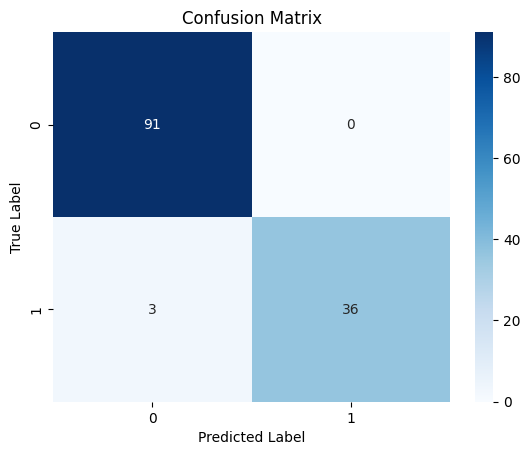

Accuracy: 0.9769230769230769
Precision: 1.0
Recall: 0.9230769230769231
F1 Score: 0.9600000000000001
MCC Score: 0.9453131868733218
Kappa Score: 0.9438202247191011
AUC Score: 0.9822485207100591


In [12]:
# Model evaluation
import torch
from sklearn.metrics import roc_auc_score  # Add this import for the AUC score

# Model evaluation
model.eval()
y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the GPU
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(outputs.cpu().numpy()[:, 1])  # Assuming binary classification with second class probabilities

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("MCC Score:", mcc)
print("Kappa Score:", kappa)
print("AUC Score:", auc)
